__BOW, классификатор изображений__

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
import numpy as np
import numpy.random as rng
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

---

In [2]:
from skimage.io import imread

UIUC Image Database for Car Detection   
https://cogcomp.seas.upenn.edu/Data/Car/

https://disk.yandex.ru/d/KEZSpmlzTekTgw

In [3]:
folder_train = 'data/cars/train'

# позитивные примеры
with open(folder_train+'/pos/index.txt','rt') as f: files = f.read()
im_train_pos = np.stack([ imread(folder_train+'/pos/'+f) for f in files.split('\n') if f ])

# негативные примеры
with open(folder_train+'/neg/index.txt','rt') as f: files = f.read()
im_train_neg = np.stack([ imread(folder_train+'/neg/'+f) for f in files.split('\n') if f ])

del files

In [4]:
im_train_pos.shape, im_train_neg.shape

((550, 40, 100), (500, 40, 100))

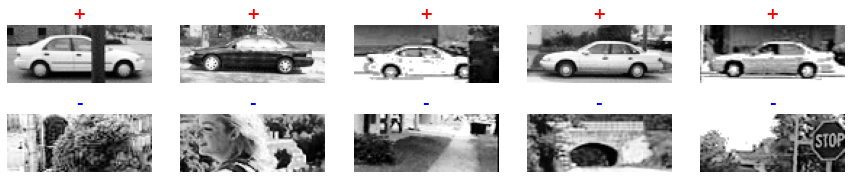

In [5]:
plt.figure(figsize=(15,3))

n_show = 5

ii = rng.permutation(  min( len(im_train_pos),len(im_train_neg) ) )[:n_show]
for n,i in enumerate(ii,start=1 ):
    plt.subplot(2,n_show,n)
    plt.axis(False)
    plt.title('+',color='r',fontdict = {'fontsize':16,'fontweight':'bold'})  
    plt.imshow(im_train_pos[i],cmap='gray')
    
    plt.subplot(2,n_show,n+n_show)
    plt.axis(False)
    plt.title('-',color='b',fontdict = {'fontsize':16,'fontweight':'bold'})  
    plt.imshow(im_train_neg[i],cmap='gray')

In [6]:
# размер учебного образа
im_train_size = im_train_pos.shape[1:]
im_train_size

(40, 100)

---

In [7]:
from skimage.feature import match_descriptors
from skimage.feature import ORB

In [11]:
descriptor_extractor = ORB(n_keypoints=10)

def extract_descriptors( im, descriptor_extractor=descriptor_extractor ):
    try:
        descriptor_extractor.detect_and_extract(im)
        d = descriptor_extractor.descriptors
        if len(d)<1:
            print('WARNING: no descriptor found')
            d=None
            
    except Exception as e:
        print('WARNING:',e)
        d = None
    return d

In [12]:
descriptors_pos = np.vstack([ 
    d for d in 
    [ extract_descriptors(im) for im in tqdm(im_train_pos) ] 
    if not (d is None) 
])

  0%|          | 0/550 [00:00<?, ?it/s]

In [13]:
descriptors_pos.shape

(1490, 256)

In [14]:
%%time 

from sklearn.cluster import KMeans

n_clusters=10
descriptors_pos_labels = KMeans(n_clusters=n_clusters).fit(descriptors_pos).labels_

CPU times: user 3.32 s, sys: 756 ms, total: 4.08 s
Wall time: 1.18 s


(array([170., 117., 131., 133., 181., 164., 160., 140., 146., 148.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

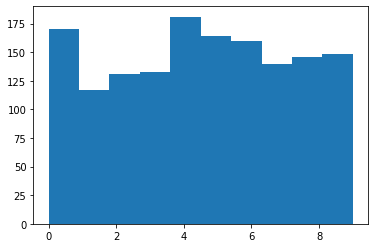

In [15]:
plt.hist( descriptors_pos_labels )

In [16]:
# - собираем датасет ( im_pos, im_neg )
# - вынимаем особые точки и их дескрипторы из im_pos
# - кластеризуем дескрипторы
# - для каждого im_pos составляем список задействованных кластеров
# - ищем соответствия pos дескрипторов в im_neg
# - для каждого im_neg составляем список задействованных кластеров

# вектор-характеристика, 
# длинна равна количеству кластеров,
# в каждой позиции количество обнаруженных дескрипторов кластера

In [28]:
from skimage.feature import match_descriptors

def extract_features(
    im, 
    descriptor_extractor=descriptor_extractor,
    descriptors_pos=descriptors_pos,
    descriptors_pos_labels=descriptors_pos_labels,
    n_clusters=n_clusters,
):
    ds = extract_descriptors(im,descriptor_extractor=descriptor_extractor,)
    if ds is None: return None # return np.zeros(n_clusters,dtype=np.uint16)
    matches = match_descriptors(ds, descriptors_pos)
    if len(matches)<1: return None  # np.zeros(n_clusters,dtype=np.uint16)
    labels = descriptors_pos_labels[ matches[:,1] ]
    return np.eye(n_clusters,dtype=np.uint16)[labels].sum(axis=0,dtype=np.uint16)

In [ ]:
X_pos = np.array([
    f for f in 
    [ extract_features(im) for im in tqdm(im_train_pos) ]
    if not (f is None)
])    

In [31]:
X_neg = np.array([
    f for f in 
    [ extract_features(im) for im in tqdm(im_train_neg) ]
    if not (f is None)
])    

  0%|          | 0/500 [00:00<?, ?it/s]

In [32]:
X_pos.shape

(477, 10)

In [33]:
X_neg.shape

(472, 10)

In [34]:
X = np.vstack([X_pos,X_neg])
target = [1]*len(X_pos) + [0]*len(X_neg)

In [35]:
%%time

from sklearn import svm
from sklearn.model_selection import train_test_split

# X_train_, _, target_train_, _ = train_test_split( X_train, target_train, test_size=.73)
# print( X_train_.shape)

model = svm.SVC().fit(X,target)

CPU times: user 30.2 ms, sys: 1e+03 ns, total: 30.2 ms
Wall time: 49.4 ms


In [38]:
%%time 

o = model.predict(X)

CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 28.6 ms


In [39]:
from sklearn.metrics import classification_report

print(classification_report(target, o) ) # , target_names=class_names) ) 

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       472
           1       0.71      0.77      0.74       477

    accuracy                           0.73       949
   macro avg       0.73      0.73      0.73       949
weighted avg       0.73      0.73      0.73       949



---

---

In [ ]:
# np.histogram(labels,bins=n_clusters)

In [ ]:
# descriptors_pos.shape

In [ ]:
# from skimage.feature import match_descriptors

# match_descriptors?

# matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

---

In [ ]:
# from skimage.color import rgb2gray
# from skimage import data

# img1 = rgb2gray(data.astronaut())
# img1 = np.floor(img1*250.).astype(np.uint8)

# img1.shape
# plt.imshow(img1)
# descriptor_extractor.detect_and_extract(img1)
# keypoints1 = descriptor_extractor.keypoints
# descriptors1 = descriptor_extractor.descriptors

In [ ]:
# keypoints1
# descriptors1.shape

In [ ]:
# from skimage import data
# from skimage import transform
# from skimage.feature import (match_descriptors, ORB, plot_matches)
# from skimage.color import rgb2gray
# import matplotlib.pyplot as plt


# img1 = rgb2gray(data.astronaut())
# img2 = transform.rotate(img1, 180)
# tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
#                                   translation=(0, -200))
# img3 = transform.warp(img1, tform)

# descriptor_extractor = ORB(n_keypoints=200)

# descriptor_extractor.detect_and_extract(img1)
# keypoints1 = descriptor_extractor.keypoints
# descriptors1 = descriptor_extractor.descriptors

# descriptor_extractor.detect_and_extract(img2)
# keypoints2 = descriptor_extractor.keypoints
# descriptors2 = descriptor_extractor.descriptors

# descriptor_extractor.detect_and_extract(img3)
# keypoints3 = descriptor_extractor.keypoints
# descriptors3 = descriptor_extractor.descriptors

# matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
# matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)

# fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,7))

# plt.gray()

# plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
# ax[0].axis('off')
# ax[0].set_title("Original Image vs. Transformed Image")

# plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
# ax[1].axis('off')
# ax[1].set_title("Original Image vs. Transformed Image")


# plt.show()

In [ ]:
# img1 = im_train_pos[1]

# descriptor_extractor.detect_and_extract(img1)

# keypoints1 = descriptor_extractor.keypoints
# descriptors1 = descriptor_extractor.descriptors

# keypoints1
# # descriptors1

---

In [ ]:
# !wget -c http://cs231n.stanford.edu/tiny-imagenet-200.zip

---

In [ ]:
# from tensorflow.keras.datasets import fashion_mnist
# (image_train, target_train),(image_test, target_test) = fashion_mnist.load_data()
# image_train.shape, image_test.shape

In [ ]:
# n_show, ppc, cpb = 9, (8,8), (2,2) # pixels per cell, cells per block

# plt.figure(figsize=(16,4))
# for n,i in enumerate(rng.permutation(len(image_train))[:n_show], start=1):
#     img = image_train[i]
#     plt.subplot(1,n_show,n)
#     plt.axis(False)
#     plt.imshow(img,cmap='gray_r')

# #     _,hog_img = hog(img,pixels_per_cell=ppc,cells_per_block=cpb,visualize=True,)
# #     plt.subplot( 2, n_show, n+n_show)
# #     plt.axis(False)
# #     plt.imshow(hog_img) #,cmap='gray_r')

---